# Requirements
pdfminer.six

chardet==3.0.4

tesseract-ocr

imagemagick

poppler-utils






In [46]:
import cv2
import matplotlib.pyplot as plt
import pytesseract
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter
from pytesseract import Output
from table_detect import find_contours
from utils import convert_key_value_pairs
pytesseract.pytesseract.tesseract_cmd = r'E:\Downloads\Tesseract OCR\tesseract.exe'

# Excel annotation

In [37]:
import pandas as pd
import json,math
def get_annotations_xlsx(path):
    """
    Input:
        @param path - The full path to the excel template
    
    Output:
        A dictionary of the following format

        {
            "page 1":[
                {
                    "label1 name":(x1,y1,x2,y2),
                    "label2 name": (x1,y1,x2,y2)
                }
            ]

            "page 2":[
                {
                    "label1 name":(x1,y1,x2,y2),
                    "label2 name": (x1,y1,x2,y2)
                }
            ]
        }
    """


    #path = './Sample images/Data.csv'
    df = pd.read_excel(path,header=None)

    annotate_dict = {}
    number_of_rows = df.shape[0]
    for r in range(0,number_of_rows):
        row1 = df.iloc[r,:]
        annotate_dict['page '+str(r+1)] = []
        for i in range(1,len(row1)):
            if str(row1[i])!='nan':
                temp_dict = eval(str(row1[i]))
                label = temp_dict['label']
                x1 = temp_dict['left']
                y1 = temp_dict['top']
                h = temp_dict['height']
                w = temp_dict['width']
                x2 = x1+w
                y2 = y1+h
                annotate_dict['page '+str(r+1)].append(
                    {
                        label:(x1,y1,x2,y2)
                    }
                )
    return annotate_dict

def plot_image(img):
    """
    Input:
        @param img - sub image for which text has to be predicted from tesseract

    Output:
        Image with title predicted by tesseract
        plt.imshow(img)
        plt.title(text)
    """

    import cv2 as cv
    import numpy as np
    from matplotlib import pyplot as plt

    text = pytesseract.image_to_string(img)
    plt.imshow(img)
    #Set title of the image as the extracted text
    plt.title(text)
    plt.show()

def predict_invoice(path,excel_path):
    import cv2 as cv
    import numpy as np
    from matplotlib import pyplot as plt

    img = cv.imread(path,0)
    plt.imshow(img)
    plt.show()
    annotations = get_annotations_xlsx(excel_path)
    
    
    for k in annotations.keys():
        annotations_list = annotations[k]
        for i in range(len(annotations_list)):
            
            for label in annotations_list[i]:
                x1,y1,x2,y2 = annotations_list[i][label]

                sub_image = img[y1:y2,x1:x2]

                plot_image(sub_image)
    find_contours(path)

# Table detect

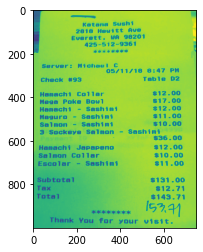

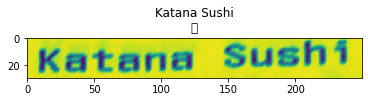

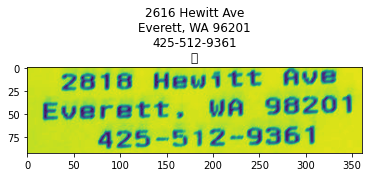

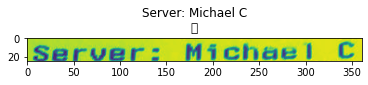

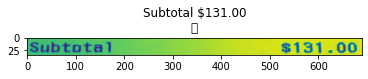

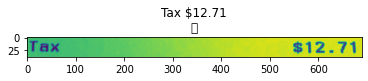

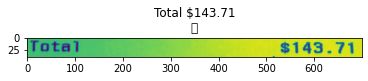

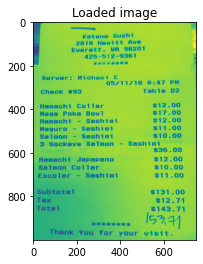

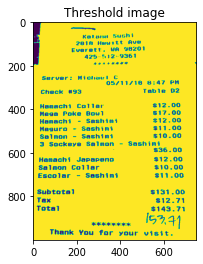

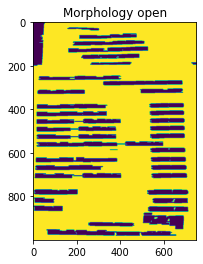

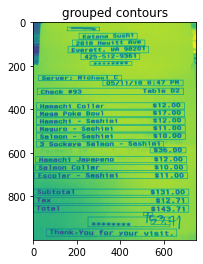

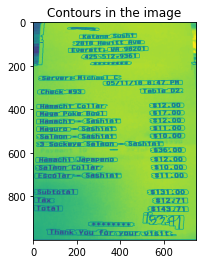

In [47]:
predict_invoice(
    'E:/Nitin/RVCE/Projects/PDF-OCR/Dataset/receipts/1007-receipt.jpg',
    './Sample images/Data-1007.xlsx'
)